In [1]:
from src import *
from data.scanner.CAVA_V1 import datasets_cava_v1
import os, sys, argparse, time

gpu = 3
torch.cuda.set_device(gpu)
dtype = torch.cuda.FloatTensor

In [2]:
def load_experiment(results_dir, model):
    param = torch.load(os.path.join(results_dir, "param.pth"))
    spec = importlib.util.spec_from_file_location("module.name", os.path.abspath(os.path.join(results_dir, os.path.basename(param.experiment.script_file_path))))
    experiment_script = importlib.util.module_from_spec(spec)
    sys.modules["module.name"] = experiment_script
    spec.loader.exec_module(experiment_script)
    exp = experiment_script.load_experiment(results_dir, model, gpu=gpu)
    return exp

In [3]:
## Testbench for the KFMLP


results_dir = "results/cava_v1/20/KFMLP/validation/225/hdr/s_t 1.0 sx 10.0 out_scale 1000.0 eps 10000.0 sigma 10.0 lambda 0.1"
model = "training/ser_highscore.pth"

exp = load_experiment(results_dir, model)

dataloader = torch.utils.data.DataLoader(exp.dataset, batch_size=1, shuffle=True, collate_fn=collocate_concat)

sample = copySampleToGPU(next(iter(dataloader)))

tic = time.time()
epoch_times = np.zeros(100)
for i in range(100):
    print(i)
    for k in range(225):

        exp.model.optimizer.zero_grad()

        kspace_hat = exp.model.evaluate_trajectory(sample["trajectory"], t_coordinates=sample["t_coordinates"])
        loss_reconstruction = exp.model.high_dynamic_range_loss(kspace_hat, sample, exp.model.param.hp.epsilon)
        denoising_loss = exp.model.denoising_loss(kspace_hat, sample["trajectory"], sigma=exp.model.param.hp.sigma, epsilon=exp.model.param.hp.epsilon)
        loss = loss_reconstruction + exp.model.param.hp.lambda_denoising_loss * denoising_loss

        loss.backward()
        exp.model.optimizer.step()
        
    epoch_times[i] = time.time()

toc = time.time()

0
1


KeyboardInterrupt: 

In [3]:
## Testbench for the t-DIP

results_dir = "results/cava_v1/20/TDIP/validation/225/z 0.5 channels 256"
model = "training/ser_highscore.pth"

exp = load_experiment(results_dir, model)

dataloader = torch.utils.data.DataLoader(exp.dataset, batch_size=1, shuffle=True, collate_fn=collocate_concat)

sample = copySampleToGPU(next(iter(dataloader)))

smaps = exp.dataset.smaps.squeeze(dim=1).type(dtype)
epoch_times = np.zeros(100)

tic = time.time()
for i in range(100):
    print(i)
    for k in range(225):

        exp.model.optimizer.zero_grad()

        img = exp.model.evaluate(sample["indices"])

        # total loss
        loss = exp.model.reconstruction_loss(img, sample, smaps)

        loss.backward()
        exp.model.optimizer.step()
        
    epoch_times[i] = time.time()

toc = time.time()

[(12, 18), (24, 36), (48, 72), (96, 144), (192, 288)]


/root/cinemri/results/cava_v1/10/TDIP/validation/225/z 0.1 channels 256/tdip.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(self.param.data.frame_times[0:self.param.data.Nk]).clone()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [5]:
# number of trainable parameters:
sum(p.numel() for p in exp.model.decoder.parameters() if p.requires_grad)

5940534

In [6]:
epoch_times2 = epoch_times.copy()
for i in range(100):
    if i == 0:
        epoch_times2[i] -= tic
    else:
        epoch_times2[i] -= epoch_times[i-1]

mean:  8.564716455936432
std:  0.08454904379566697


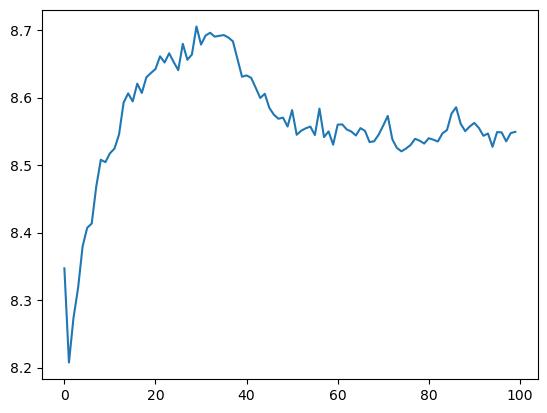

In [7]:
plt.plot(epoch_times2)
print("mean: ", np.mean(epoch_times2))
print("std: ", np.std(epoch_times2))